# Mmdetection Baseline

## Imports and Seed Everything

In [1]:
import sys
import os
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check MMDetection installation
from mmdet.apis import set_random_seed

# Imports
import mmdet
from mmdet.apis import set_random_seed
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

import random
import numpy as np
from pathlib import Path

1.8.0 True
10.2
GCC 7.3


In [2]:
global_seed = 111

def set_seed(seed=global_seed):
    """Sets the random seeds."""
    set_random_seed(seed, deterministic=False)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

## Prepare the MMDetection Config

In [3]:
from mmcv import Config

baseline_cfg_path = "../mmdetection/configs/cascade_rcnn/cascade_rcnn_x101_32x4d_fpn_1x_coco.py"
cfg = Config.fromfile(baseline_cfg_path)
# print(cfg.pretty_text)

## General Training Settings

In [4]:
model_name = 'cascade_rcnn_x101_32x4d_fpn_1x'
fold = 0
job = 1

# Folder to store model logs and weight files
job_folder = f'./working/job{job}_{model_name}_fold{fold}'
cfg.work_dir = job_folder

# Change the wnd username and project name below
wnb_username = 'nekokiku'
wnb_project_name = 'cow-boy-detection'

# Set seed thus the results are more reproducible
cfg.seed = global_seed

if not os.path.exists(job_folder):
    os.makedirs(job_folder)

print("Job folder:", job_folder)

Job folder: ./working/job1_cascade_rcnn_x101_32x4d_fpn_1x_fold0


In [5]:
# Set the number of classes
for head in cfg.model.roi_head.bbox_head:
    head.num_classes = 5
# cfg.model.roi_head.bbox_head.num_classes = 5

cfg.gpu_ids = [4]

# Setting pretrained model in the init_cfg which is required 
# for transfer learning as per the latest MMdetection update
# cfg.model.backbone.init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')
# cfg.model.backbone.init_cfg=dict(type='Pretrained', checkpoint='open-mmlab://resnext101_32x4d')
# cfg.model.pop('pretrained', None)

cfg.runner.max_epochs = 12 # Epochs for the runner that runs the workflow 
cfg.total_epochs = 12

# Learning rate of optimizers. The LR is divided by 8 since the config file is originally for 8 GPUs
cfg.optimizer.lr = 0.02/4

## Learning rate scheduler config used to register LrUpdater hook
cfg.lr_config = dict(
    policy='CosineAnnealing', # The policy of scheduler, also support CosineAnnealing, Cyclic, etc. Refer to details of supported LrUpdater from https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/lr_updater.py#L9.
    by_epoch=False,
    warmup='linear', # The warmup policy, also support `exp` and `constant`.
    warmup_iters=500, # The number of iterations for warmup
    warmup_ratio=0.001, # The ratio of the starting learning rate used for warmup
    min_lr=1e-07)

# config to register logger hook
cfg.log_config.interval = 20 # Interval to print the log

# Config to set the checkpoint hook, Refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/checkpoint.py for implementation.
cfg.checkpoint_config.interval = 1 # The save interval is 1

## Dataset

In [6]:
cfg.dataset_type = 'CocoDataset' # Dataset type, this will be used to define the dataset
cfg.classes = ("belt","sunglasses","boot","cowboy_hat","jacket")
cfg.data_root = '/cowboydata'

cfg.data.train.img_prefix = './cowboydata/images' # Prefix of image path
cfg.data.train.classes = cfg.classes
cfg.data.train.ann_file = './cowboydata/train.json'
cfg.data.train.type='CocoDataset'

cfg.data.val.img_prefix = './cowboydata/images' # Prefix of image path
cfg.data.val.classes = cfg.classes
cfg.data.val.ann_file = './cowboydata/train.json'
cfg.data.val.type='CocoDataset'

cfg.data.test.img_prefix = './cowboydata/images' # Prefix of image path
cfg.data.test.classes = cfg.classes
cfg.data.test.ann_file =  './cowboydata/train.json'
cfg.data.test.type='CocoDataset'

cfg.data.samples_per_gpu = 2 # Batch size of a single GPU used in testing
cfg.data.workers_per_gpu = 2 # Worker to pre-fetch data for each single GPU

## Setting Metric for Evaluation

In [7]:
cfg.evaluation.metric = 'mAP' # Metrics used during evaluation

# Set the epoch intervel to perform evaluation
cfg.evaluation.interval = 1

# Set the iou threshold of the mAP calculation during evaluation
cfg.evaluation.iou_thrs = [0.5]

In [ ]:
cfg.log_config.hooks = [dict(type='TextLoggerHook'),
                        dict(type='WandbLoggerHook',
                             init_kwargs=dict(project=wnb_project_name,
                                              name=f'exp-{model_name}-fold{fold}-job{job}',
                                              entity=wnb_username))
                       ]

## Save Config File

In [8]:
cfg.dump(F'{cfg.work_dir}/my_config.py')

## Build Dataset and Start Training

In [9]:
model = build_detector(cfg.model,
                       train_cfg=cfg.get('train_cfg'),
                       test_cfg=cfg.get('test_cfg'))
model.init_weights()

/home/tantianlong/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '
2021-07-20 21:41:17,991 - mmcv - INFO - load model from: open-mmlab://resnext101_32x4d
2021-07-20 21:41:17,992 - mmcv - INFO - Use load_from_openmmlab loader


In [10]:
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [22]:
# train_detector(model, datasets[0], cfg, distributed=False, validate=False)

In [23]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
config = './working/job1_retinanet_r50_fpn_1x_fold0/my_config.py'
# Setup a checkpoint file to load
checkpoint = './working/job1_retinanet_r50_fpn_1x_fold0/latest.pth'
# initialize the detector
model = init_detector(config, checkpoint, device='cuda:4')

Use load_from_local loader


/home/tantianlong/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


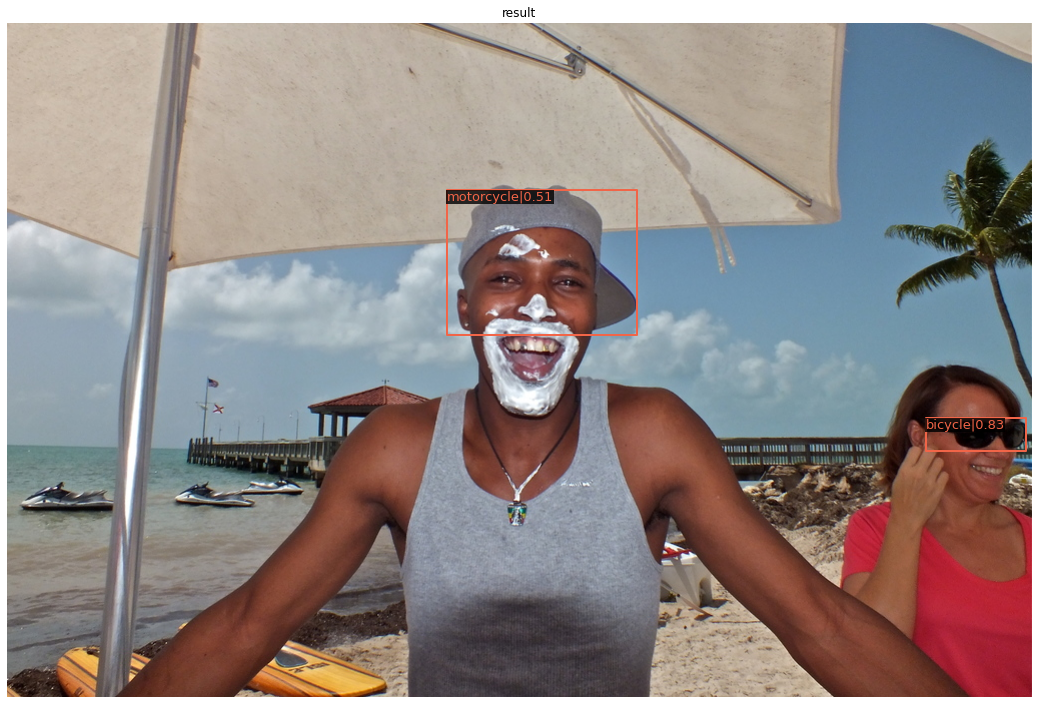

In [47]:
# Use the detector to do inference
img = './cowboydata/images/9c03b168ff330d8a.jpg'
result = inference_detector(model, img)
score_thresh = 0.2
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=score_thresh)

In [48]:
classes = ('belt', 'sunglasses', 'boot', 'cowboy_hat', 'jacket')
classes_id = ('87', '1034', '131', '318', '588')

img_id = '1'
for i in range(5):
    if len(result[i]) != 0:
#         print(classes[i])
#         print(classes_id[i])
        for j in result[i]:
            if j[-1] >= score_thresh:
                pred = {'image_id': img_id,
                        'category_name': classes[i],
                        'category_id': classes_id[i],
                        'bbox': [j[0], j[1], j[2], j[3]],
                        'score': j[-1]}
                print(pred)

{'image_id': '1', 'category_name': 'sunglasses', 'category_id': '1034', 'bbox': [918.48157, 395.319, 1018.0423, 428.27414], 'score': 0.8267803}
{'image_id': '1', 'category_name': 'cowboy_hat', 'category_id': '318', 'bbox': [439.86404, 167.35277, 629.6926, 312.61423], 'score': 0.50684196}


In [60]:
from tqdm import tqdm
classes = ('belt', 'sunglasses', 'boot', 'cowboy_hat', 'jacket')
classes_id = ('87', '1034', '131', '318', '588')
def create_submission(df, model, score_thresh=0.5):
    results = []
    for index, row in tqdm(df.iterrows()):
        img_id = row['id']
        file_name = row['file_name']
        img_base = './cowboydata/images/'
        img = img_base + file_name
        result = inference_detector(model, img)
        
        for i in range(5):
            if len(result[i]) != 0:
                for j in result[i]:
                    j = np.array(j).tolist()
                    if j[-1] >= score_thresh:
                        pred = {'image_id': img_id,
                                'category_id': int(classes_id[i]),
                                'bbox': [j[0], j[1], j[2], j[3]],
                                'score': j[-1]}
                        results.append(pred)
    return results

In [61]:
import pandas as pd
val_path = './cowboydata/valid.csv'
submission_df = pd.read_csv(val_path)
submission = create_submission(submission_df, model)

999it [02:28,  6.71it/s]


In [64]:
import json  # for dumping json serialized results
import zipfile  # for creating submission zip file
# create json and zip

submission_name = './submission/answer.json'
with open(submission_name, 'w') as f:
    json.dump(submission, f)
zf = zipfile.ZipFile('./submission/my_answer.zip', 'w')
zf.write(submission_name, 'answer.json')
zf.close()

In [59]:
classes = ('belt', 'sunglasses', 'boot', 'cowboy_hat', 'jacket')
classes_id = ('87', '1034', '131', '318', '588')
score_thresh = 0.5

import pandas as pd
import numpy as np
val_path = './cowboydata/valid.csv'

results = []
df = pd.read_csv(val_path) 
for index, row in df.iterrows():
    img_id = row['id']
    file_name = row['file_name']
    img_base = './cowboydata/images/'
    img = img_base + file_name
    result = inference_detector(model, img)
    for i in range(5):
        if len(result[i]) != 0:
            for j in result[i]:
                j = np.array(j).tolist()
                if j[-1] >= score_thresh:
                    pred = {'image_id': img_id,
                            'category_id': int(classes_id[i]),
                            'bbox': [j[0], j[1], j[2], j[3]],
                            'score': j[-1]}
                    print(pred)

{'image_id': 2817499345625518079, 'category_id': 588, 'bbox': [236.35714721679688, 403.48529052734375, 383.14849853515625, 607.6295166015625], 'score': 0.9655360579490662}
{'image_id': 2817499345625518079, 'category_id': 588, 'bbox': [51.158424377441406, 415.7470703125, 204.82716369628906, 629.6118774414062], 'score': 0.9625812768936157}
{'image_id': 2817499345625518079, 'category_id': 588, 'bbox': [706.8570556640625, 428.70220947265625, 766.5338134765625, 588.7379150390625], 'score': 0.8937251567840576}
{'image_id': 2817499345625518079, 'category_id': 588, 'bbox': [178.33395385742188, 425.034423828125, 251.20741271972656, 587.5120849609375], 'score': 0.5686675310134888}
{'image_id': 4780409558104969215, 'category_id': 588, 'bbox': [249.88755798339844, 183.18528747558594, 526.5663452148438, 665.5963745117188], 'score': 0.9957439303398132}
{'image_id': 4780409558104969215, 'category_id': 588, 'bbox': [555.1069946289062, 212.23426818847656, 854.7886352539062, 683.0], 'score': 0.979862749

KeyboardInterrupt: 